In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from stock_analysis import StockReader
from stock_analysis.utils import group_stocks, make_portfolio

In [2]:
start_date = '2014-01-01'
end_date = '2024-01-01'
reader = StockReader(start_date, end_date)

In [3]:
# get FAANG data
fb, aapl, amzn, nflx, goog = (
    reader.get_ticker_data(ticker)
    for ticker in ['META', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
)

In [4]:
# group FAANG data
faang = group_stocks(
    {
        'Facebook': fb,
        'Apple': aapl,
        'Amazon': amzn,
        'Netflix': nflx,
        'Google': goog
    }
)

# create faang portfolio, clean data
faang_portfolio = make_portfolio(faang)
del faang_portfolio['high']
del faang_portfolio['low']
del faang_portfolio['open']
del faang_portfolio['name']

# calculate and add daily returns
faang_portfolio['daily_return']= faang_portfolio['close'].pct_change()
faang_portfolio.to_csv('faang_portfolio_data/faang_portfolio.csv')
faang_portfolio = faang_portfolio.dropna()
faang_portfolio.tail()

,adj_close,close,volume,daily_return
date,,,,
2023-12-22,1329.643311,1329.890030,99562900,-0.004588
2023-12-26,1335.053986,1335.300003,77089700,0.004068
2023-12-27,1337.303833,1337.549988,112580000,0.001685
2023-12-28,1336.823318,1337.070023,86808700,-0.000359
2023-12-29,1325.994629,1326.239990,115010500,-0.008100


In [5]:
# get Fama French Five Factor Model Data
famafrench = pd.read_csv('famafrench_data/F-F_Research_Data_5_Factors_2x3_daily.CSV', skiprows=3, index_col=0)
famafrench['date'] = pd.to_datetime(famafrench.index, format='%Y%m%d')
famafrench.set_index('date', inplace=True)

# convert to percentage
famafrench[['Mkt-RF', 'SMB', 'HML', 'RF']] = famafrench[['Mkt-RF', 'SMB', 'HML', 'RF']] / 100
famafrench.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF
date,,,,,,
2023-12-22,0.0021,0.0061,0.0009,-0.64,0.19,0.00021
2023-12-26,0.0048,0.0081,0.0046,-0.34,-0.15,0.00021
2023-12-27,0.0016,0.0016,0.0012,-0.31,-0.14,0.00021
2023-12-28,-0.0001,-0.0038,0.0003,-0.32,0.15,0.00021
2023-12-29,-0.0043,-0.0113,-0.0037,0.67,-0.07,0.00021


In [6]:
# merge the dataframes based on the date index
merged_data = famafrench.join(faang_portfolio['daily_return'], how='inner')
merged_data.to_csv('faang_portfolio_data/merged_data.csv')
merged_data.head()

## note: python automatically fits time frame data

,Mkt-RF,SMB,HML,RMW,CMA,RF,daily_return
date,,,,,,,
2014-01-03,0.0003,0.0040,0.0004,-0.36,0.14,0.0,-0.004730
2014-01-06,-0.0034,-0.0054,0.0029,-0.32,0.10,0.0,0.013908
2014-01-07,0.0068,0.0031,-0.0037,-0.07,-0.27,0.0,-0.008715
2014-01-08,0.0004,-0.0001,-0.0011,-0.48,-0.02,0.0,0.005165
2014-01-09,0.0002,0.0017,-0.0044,-0.54,-0.42,0.0,-0.012237


In [7]:
# calulate residual returns
merged_data['residual_return'] = merged_data.daily_return - merged_data.RF

merged_data.tail()

,Mkt-RF,SMB,HML,RMW,CMA,RF,daily_return,residual_return
date,,,,,,,,
2023-12-22,0.0021,0.0061,0.0009,-0.64,0.19,0.00021,-0.004588,-0.004798
2023-12-26,0.0048,0.0081,0.0046,-0.34,-0.15,0.00021,0.004068,0.003858
2023-12-27,0.0016,0.0016,0.0012,-0.31,-0.14,0.00021,0.001685,0.001475
2023-12-28,-0.0001,-0.0038,0.0003,-0.32,0.15,0.00021,-0.000359,-0.000569
2023-12-29,-0.0043,-0.0113,-0.0037,0.67,-0.07,0.00021,-0.008100,-0.008310


# Regression Statistics and Results

### Fama French's Five Factor Model Equation

![fivefactor_equation.png](images/fivefactor_equation.png)


In [8]:
# prepare data for regression
y = merged_data['residual_return']
X = merged_data[['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']]

X_sm = sm.add_constant(X)

# regression
model = sm.OLS(y, X_sm).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        residual_return   R-squared:                       0.637
Model:                            OLS   Adj. R-squared:                  0.636
Method:                 Least Squares   F-statistic:                     880.9
Date:                Tue, 13 Feb 2024   Prob (F-statistic):               0.00
Time:                        22:40:50   Log-Likelihood:                 7704.9
No. Observations:                2515   AIC:                        -1.540e+04
Df Residuals:                    2509   BIC:                        -1.536e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.782      0.0

### Results

Based on the regression analysis of the Fama French five-factor model for the portfolio of FAANG stocks (Facebook, Apple, Amazon, Netflix, and Google) from 2014-2024, the following results were obtained:

1. **R-Squared Statistic**: The R-squared statistic is 63.7%, indicating that approximately 63.7% of the variance in the portfolio's residual return is explained by the independent variables in the model.

2. **Alpha (const)**: The alpha (constant) is 0.0004. This coefficient represents the excess return of the portfolio beyond what would be expected given its exposure to the market and other factors. A positive alpha indicates outperformance relative to the market.

3. **Market Risk Premium (Mkt-RF)**: The coefficient for the market risk premium (Mkt-RF) is 1.0698. A beta greater than 1 (1.0698) indicates that the portfolio has higher volatility compared to the market.

4. **Size (SMB)**: The coefficient for size (SMB) is -0.2162. A negative coefficient suggests that the portfolio tends to have exposure to larger stocks. This makes sense with our portfolio because FAANG consists solely of Big Tech.

5. **Value (HML)**: The coefficient for value (HML) is -0.4030. A negative coefficient indicates that the portfolio tends to have exposure to growth stocks.

6. **Operating Profitability (RMW)**: The coefficient for operating profitability (RMW) is -0.0005. This coefficient is not statistically significant, suggesting that operating profitability may not have a significant impact on the portfolio's performance during this period.

7. **Investment (CMA)**: The coefficient for investment (CMA) is -0.0081. This coefficient is statistically significant, indicating that the portfolio's performance may be affected by investment activities.

These results provide insights into the factors influencing the performance of the FAANG portfolio during the specified time period, highlighting its exposure to market risk, size, and value factors.


### Visualization

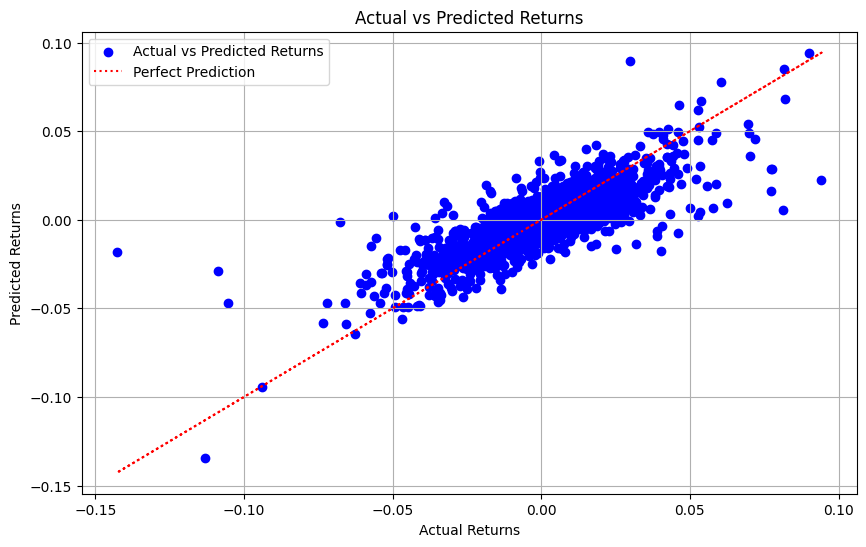

In [9]:
# plot actual vs predicted returns
plt.figure(figsize=(10, 6))
plt.scatter(y, model.predict(X_sm), color='blue', label='Actual vs Predicted Returns')
plt.plot(y, y, color='red', linestyle=':', label='Perfect Prediction')
plt.title('Actual vs Predicted Returns')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.legend()
plt.grid(True)
plt.savefig('faang_portfolio_data/actual_vs_predicted_returns.png')
plt.show()